# Ante Proyecto Trabajo Práctico Comunicaciones Digitales

#### Proyecto: Sensado de la potencia de campo electromagnético en la zona lejana de Antenas (CONAE)

Grupo de trabajo: `La Banda Ancha de Amigos`

Integrantes:
- Cabrera Augusto Gabriel
- Mansilla Josías Leonel
- Moroz Esteban Mauricio
- Villar Federico Ignacio

### Desarrollo del código

En este notebook se desarrollarán diferentes ejemplos de uso de un SDR. Para el caso, se prueba Python con un RTLSDR 820T. Cada uno de estos diferentes bloques corren sobre frecuencias centrales propias de la localidad de Embalse, Córdoba, y que son medibles con un dispositivo de esta categoría. Cuando se hagan las pruebas en el campo se utilizará un SDR ADALM-Pluto, de Analog Devices. 

Se importan las librerías a usar:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rtlsdr import RtlSdr
from scipy import signal
import geopandas as gpd
from shapely.geometry import Point

Se crea el objeto SDR y se le asignan diferentes parámetros de configuración.

In [2]:
sdr = RtlSdr()
sdr.sample_rate = 2.4e6
sdr.center_freq = 103.7e6 # Radio La Brújula
sdr.gain = 'auto'
samples = sdr.read_samples(256*1024)

Found Fitipower FC0012 tuner


#### Medición del Campo Electromagnético

En el siguiente bloque de código, en donde se mide la potencia media de las muestras en [dbFS] para luego imprimirla.

In [3]:
power = np.abs(samples)**2 
power_db = 10*np.log10(np.mean(power))
print('Intensidad de campo electromagnético: %0.2f dBFS' % power_db)

Intensidad de campo electromagnético: -1.71 dBFS


#### Transformada Rápida de Fourier

El algoritmo de la transformada rápida de Fourier puede reducir el tiempo necesario para encontrar la transformada discreta de Fourier de varios minutos a menos de un segundos. Se explica brevemente el diezmado en el tiempo.
##### Diezmado en el tiempo
Es el algoritmo más famoso para el cálculo de una FFT, diseñado Cooley y Tukey en 1965. Tomando como entrada una señal discreta $x[n]$ con $N$ muestras, se basa en dividir la señal de entrada en otras dos señales de $\frac{N}{2}$ muestras (por un lado los coeficientes pares y por otro los impares), y se envían cada una de estas subseñales a una FFT de tamaño $\frac{N}{2}$ puntos. Cada uno de los coeficientes de salida de la FFT de las muestras impares se multiplica por $W_N ^K = e^{-i\frac{2\pi}{N}}k$, donde $k$ es la posición del vector salida, y se suma a las muestras pares. A su vez, las FFT de $\frac{N}{2}$ puntos se pueden resolver de esta misma manera, realizando esta operación de manera ercursiva hasta obtener una FFT de una señal de tamaño 2, cuyo resultado:
$$
X[0] = x[0]+x[1]
X[1] = x[0]-x[1]
$$


En el siguiente código se obtiene la transformada rápida de Fourier. 

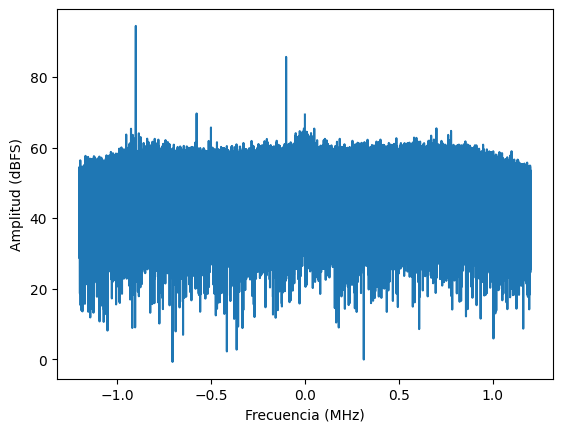

In [4]:
fft = np.fft.fft(samples)
freq = np.fft.fftfreq(len(samples), 1/sdr.sample_rate)
plt.plot(freq/1e6, 20*np.log10(np.abs(fft)))
plt.xlabel('Frecuencia (MHz)')
plt.ylabel('Amplitud (dBFS)')
plt.show()

#### Densidad Espectral de Potencia

La densidad espectral de potencia, PSD (por sus siglas) se puede obtener haciendo uso de `matplotlib`, tal como se muestra a continuación.

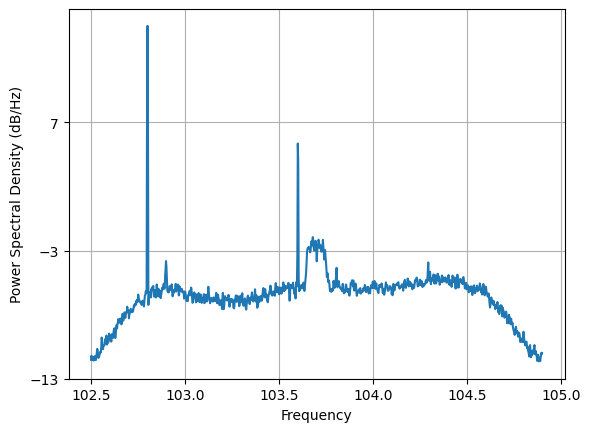

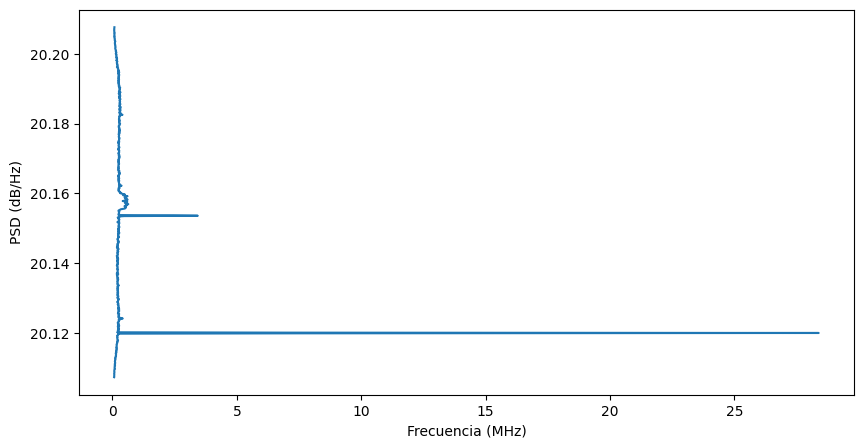

In [5]:
f, Pxx = plt.psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
plt.figure(figsize=(10, 5))
plt.plot(f, 10*np.log10(Pxx))
plt.xlabel('Frecuencia (MHz)')
plt.ylabel('PSD (dB/Hz)')
plt.show()

#### Espectrograma

Otro gráfico útil en el uso de un SDR es el espectrograma. A continuación se muestra cómo obtener uno.

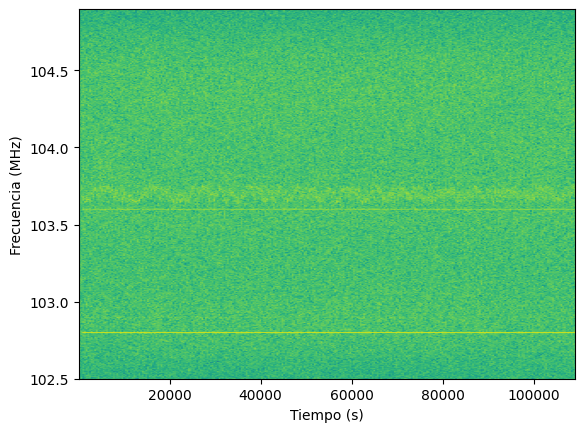

In [18]:
plt.specgram(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (MHz)')
plt.show()

#### Modulación de QPSK

Es posible diagramar un escaner de QPSK. Para ello se toman $n$ muestras de la señal, y luego se las aproxima a las recibidas por una aproximación del método de modulación digital QPSK. A continuación el código.

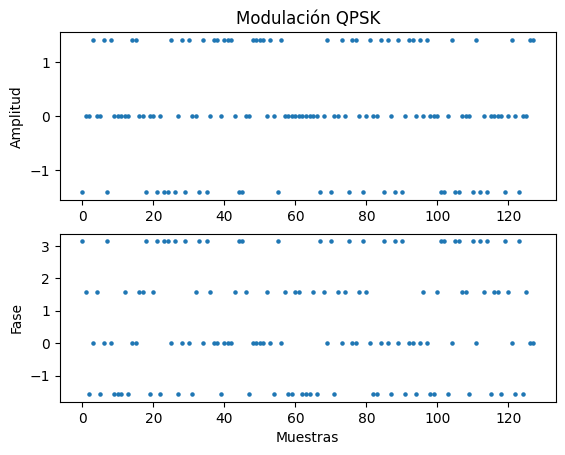

In [7]:
sample = sdr.read_samples(256)
bits = np.real(sample) > 0
bits = bits.astype(int)
bits = 2*bits - 1
symb = np.zeros(len(bits)//2, dtype=complex)
symb.real = (bits[::2] + bits[1::2])/np.sqrt(2)
symb.imag = (bits[::2] - bits[1::2])/np.sqrt(2)
fig, axs = plt.subplots(2, 1)
axs[0].scatter(range(len(symb)), symb.real, s=5)
axs[0].set_ylabel('Amplitud')
axs[0].set_title('Modulación QPSK')
axs[1].scatter(range(len(symb)), np.angle(symb), s=5)
axs[1].set_ylabel('Fase')
axs[1].set_xlabel('Muestras')
plt.show()

#### Scanner en QPSK

Con el mismo procedimiento de antes, es posible también obtener un diagrama de modulación para QPSK.

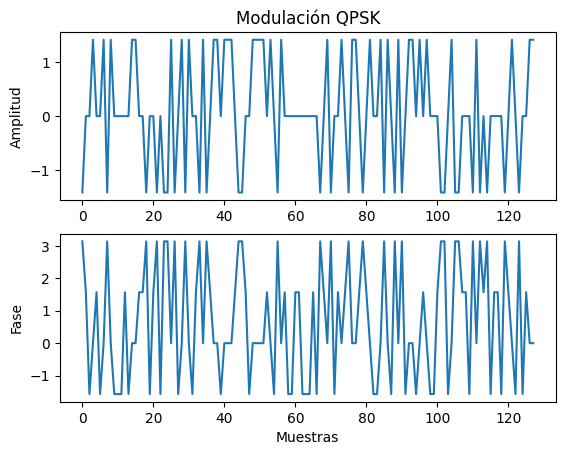

In [8]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(symb.real)
axs[0].set_ylabel('Amplitud')
axs[0].set_title('Modulación QPSK')
axs[1].plot(np.angle(symb))
axs[1].set_ylabel('Fase')
axs[1].set_xlabel('Muestras')

plt.show()

#### Diagrama de constelaciones BPSK

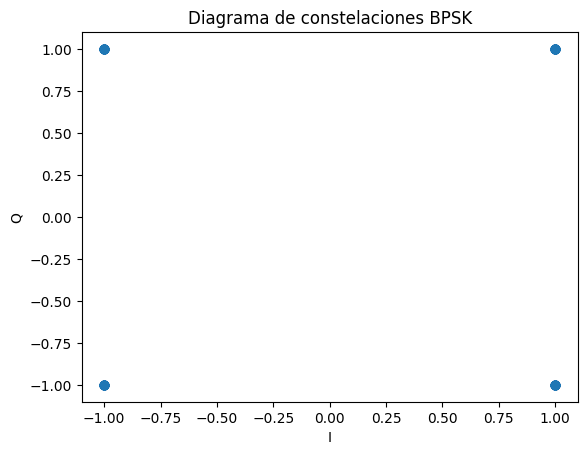

In [9]:
symb = np.zeros(len(bits)//2, dtype=complex)
symb.real = bits[::2]
symb.imag = bits[1::2]
plt.scatter(symb.real, symb.imag)
plt.xlabel('I')
plt.ylabel('Q')
plt.title('Diagrama de constelaciones BPSK')
plt.show()

#### Mapa de Calor

Se simula a continuación un mapa de calor, para el cual se graficarían diferentes puntos que representarían la intensidad del campo electromagnético para ciertas coordenadas. El ejemplo mostrado a continuación es meramente ilustrativo, ya que tanto las coordenadas, como el valor de la intensidad del campo electromagnético se obtienen a partir de funciones aleatorias.

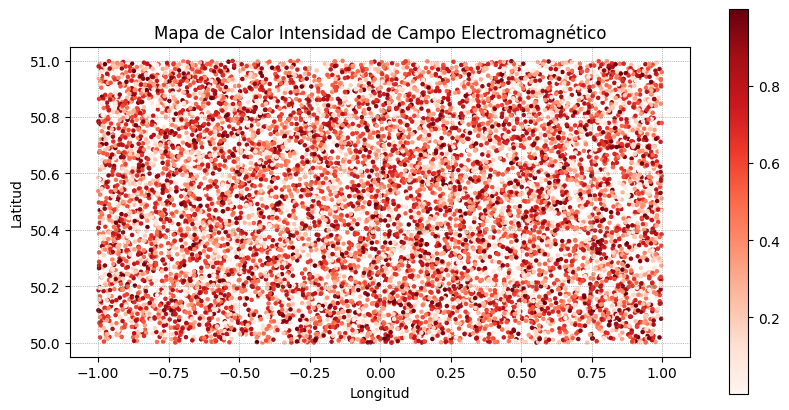

In [10]:
nPoints = 10000
lat = np.random.uniform(50.0, 51.0, nPoints)
lon = np.random.uniform(-1.0, 1.0, nPoints)
geometry = [Point(xy) for xy in zip(lon, lat)]
df = gpd.GeoDataFrame({'intensidad': np.random.rand(nPoints)}, geometry=geometry)
fig, ax = plt.subplots(figsize=(10, 10))
df.plot(column='intensidad', cmap='Reds', markersize=5, alpha=1, legend=True, 
        ax=ax, legend_kwds={'shrink': 0.5})
ax.grid(True, linestyle=':', linewidth=0.5, color='gray')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_title('Mapa de Calor Intensidad de Campo Electromagnético')
plt.show()

### Idea de Implementación

Se tiene una primera idea de cómo sería la implementación del sistema de muestreo. Se haría en base a los siguientes pasos tentativos:

1. Armar un circuito que cuente con una Raspberry Pi, un SDR y un módulo de GPS. Se obvia la parte de alimentación.
2. Se define un período de muestreo en base al área a barrer para el sensado.
3. Se obtienen en cada muestra 3 datos: 
- Latitud
- Longitud
- $n$ muestras de la señal
4. Se almacenan los datos en un data frame.
5. Se procesa la información y se exporta en algún formato específico (por ejemplo: Excel).
6. Se obtiene un gráfico interactivo del tipo de mapa de calor. En él, uno puede seleccionar la variable de interés (intensidad de campo, PSD, etc) y obtiene un mapa en función de esta variable. De forma tentativa, este último paso se haría de forma externa a Python, probablemente con Javascript.